# Sentiment Polarity with `TextBlob`

### What is Natural Language processing anyways?

Let's ask Wikipedia for a start. 

*Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data. The result is a computer capable of "understanding" the contents of documents, including the contextual nuances of the language within them. The technology can then accurately extract information and insights contained in the documents as well as categorize and organize the documents themselves.*

Perfect. This is exactly what we want to achieve with this Notebook.

### What is this Notebook for? 

This is an introductory Jupyter Notebook, written with the intent to: 

* familiarize with NLP methods and gather knowledge in the field
* discover basic techniques for categorizing text in NLP 
* identify potential use cases for our business org where we can apply NLP, such as: 
** automatically categorizing feedback from report users
** discover patterns and classes in text fields such as project notes 

## Next comes a bit more techy information about the python libraries. Feel free to skip right to the code.

### THE 5 NLP libraries

There are dozens of packages for Natural Language processing out there… Do I need to learn every library below?

No.

It all depends on your use case. 


### Here’s a high level summary on 5 pretty famous libraries:

`NLTK`

* We recommend NLTK only as an education and research tool. 
* Its modularized structure makes it excellent for learning and exploring NLP concepts, but it’s not meant for production.

`TextBlob` 
* ...is built on top of NLTK, and it’s more easily-accessible. 
* Great library for fast-prototyping or building applications that don’t require highly optimized performance. (Beginners should start here.)

`Stanford’s CoreNLP` 
* is a Java library with Python wrappers. 
* It’s in many existing production systems due to its speed.

`SpaCy` 
* ...is a new NLP library that’s designed to be fast, streamlined, and production-ready. 
* It’s not as widely adopted, but if you’re building a new application, you should give it a try.

`Gensim` 
* ...is most commonly used for topic modeling and similarity detection. 
* It’s not a general-purpose NLP library, but for the tasks it does handle, it does them well.


### Let's have a closer look at TextBlob

* TextBlob is built on top of `NLTK` and another package called `Pattern`. 
* TextBlob makes text processing simple by providing an intuitive interface to NLTK. 
* For example, let’s say you wanted to find a text’s sentiment score. You can do that out of the box with 
* By default, the sentiment analyzer is the PatternAnalyzer from the Pattern library. But we can easily swap to e.g. pre-trained NLTK implementation of Naive Bayes analyzer.
* TextBlob is a simple, fun library that makes text analysis a joy. We can use TextBlob for initial prototyping for almost every NLP project.


----------
TextBlob library documentation: https://textblob.readthedocs.io/en/dev/
Article Reference: https://elitedatascience.com/python-nlp-libraries 


In [1]:
# See how easy it can be to classify sentiment with textblob. Just 3 (!!) lines of code. 

from textblob import TextBlob
opinion = TextBlob("Our team is simply great.")
opinion.sentiment

Sentiment(polarity=0.8, subjectivity=0.75)

Let's get started: 


# 1) Getting the data

* We do not yet have a lot of text data from customer survey feedback. So I'll use semantically quite similar data from PowerBI Youtube Tutorial comments
* The python file downloader.py can be used to get all youtube comments from a PowerBI Tutorial video with 1,351 comments
* Video URL: https://www.youtube.com/watch?v=AGrl-H87pRU


In [2]:
# import python packages
import pandas as pd
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

# Load english NLTK model with stopwords 
# Stopwords are pre-defined words with no information, such as I, You, Me, Mine ...
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') 
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/fred/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/fred/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/fred/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Use downloader.py to scrape youtube comments. For this demo I decided to load comments from some of the most discussed PowerBI youtube Tutorials. 

comments = pd.read_json(r'/Users/fred/OneDrive - Adobe/Data/NLP_sentiment/Youtube_Comments/AGrl-H87pRU_comments.json', lines=True) 
comments.head(5)

# What about only comments from watchers (not Avi)? 
# Uncomment below to see what "the audience" is discussing

# comments = comments[comments.author != "Avi Singh - PowerBIPro"]
# comments = comments.reset_index(drop=True)

# Let's take a look at our dataset: 
print("This dataset contains", len(comments), "comments.")
comments.head()

This dataset contains 1347 comments.


,cid,text,time,author,channel,votes,photo,heart
0,UgxEKSte91wf3x98TfB4AaABAg,If you get stuck anywhere in the Tutorial or w...,vor 1 Jahr,Avi Singh - PowerBIPro,UCRNmSv7mAPYiC0Y40TJijAw,75,https://yt3.ggpht.com/ytc/AAUvwnjX_BvV7K8NzNKj...,False
1,UgxEKSte91wf3x98TfB4AaABAg.8uSDdrzshTs8wFyAAfhLYE,What time on Friday?,vor 1 Jahr,Vesna Popovic,UCzwYyMBo_XrMOhQ_uvrAT9Q,1,https://yt3.ggpht.com/ytc/AAUvwnh_JcD9EAzIzIuo...,False
2,UgxEKSte91wf3x98TfB4AaABAg.8uSDdrzshTs8xR0wikNFVR,Every 9am PST,vor 1 Jahr,Avi Singh - PowerBIPro,UCRNmSv7mAPYiC0Y40TJijAw,0,https://yt3.ggpht.com/ytc/AAUvwnjX_BvV7K8NzNKj...,False
3,UgxEKSte91wf3x98TfB4AaABAg.8uSDdrzshTs90EUBjAbn1D,"Hello Avi,\nI have downloaded the AdventureWor...",vor 1 Jahr,Archana Kshirsagar,UC95fp-9Ud9LlT4famCAuRwA,0,https://yt3.ggpht.com/ytc/AAUvwngjwgKhi4t2A4Ev...,False
4,UgxEKSte91wf3x98TfB4AaABAg.8uSDdrzshTs918cGeqxOL9,Where are the practice files please,vor 1 Jahr,Lola Luf,UCAazHQ0xB2OKD1ULDGm_f8A,7,https://yt3.ggpht.com/ytc/AAUvwniuvhwulBXEDOGB...,False


## Text pre-processing

This part of the Notebook will prepare the dataset so that we can actually use it for sentiment analysis. 

In [4]:
# Drop columns that are not needed
comments = comments.drop(['cid', 'time', 'author', 'channel', 'votes', 'photo', 'heart'], axis=1)

In [5]:
# Let's take a look at the first line of our dataset now
pd.options.display.max_colwidth = 5000
print(comments[:1])

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               text
0  If you get stuck anywhere in the Tutorial or when applying these principles using your own data, then subscribe & join me LIVE on TalkPowerBI Fridays and bring in all your questions! \n⚡ Link to Live Stream: https://www.youtube.com/PowerBIPro/live\n⚡Upcoming Live Stream Schedule: https://www.youtube.com/user/ModernExcel/videos?view=2&sort=dd&live_view=502&shelf_id=17\n⚡ Recording of Past TalkPowerBI LIVE https://www.youtube.com/playlist?list=PL7GQQXV5Z8efJcW9AYK-4s3YMQg2EMjkO


There is still a lot of weird signs, URLs and other text which needs to be extracted. Take a look at the next cell. 

In [6]:
# Define a general function to apply standard text cleaning measures on text data
# Later we can apply this function on our dataset

def clean_text(text):
    """
    Remove all capital letters, punctuations, emojis, links, etc. Basically, removing all that is not words or numbers.
    Tokenize the data into words, which means breaking up every comment into a group of individual words.
    Remove all capital letters, punctuations, emojis, links, etc. Basically, removing all that is not words or numbers.
    """

    # Remove non-words
    text = text.lower()
    text = re.sub('@', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z ]+", "", text)

    # Tokenize
    text = nltk.word_tokenize(text)

    # Remove Stopwords
    text = [w for w in text if w not in sw]

    return text

# ACS INSIGHTS QUESTIONS: Could such a functino help us import text into ACS Insights? 
# If we need this text in a pre-processed form anyways. Could this text format be included into ACS Insights?

In [7]:
# Apply clean_text function to the the youtube comments data
comments['text'] = comments['text'].apply(lambda x: clean_text(x))

In [8]:
# Let's take another look at the dataset. 
print(comments[:1])

                                                                                                                                                                                                                           text
0  [get, stuck, anywhere, tutorial, applying, principles, using, data, subscribe, join, live, talkpowerbi, fridays, bring, questions, link, live, stream, upcoming, live, stream, schedule, recording, past, talkpowerbi, live]


Way better! We now only have important tokens as a list for each sentence in the dataset. 
However, we can do better! Let's further reduce the amount of text with ```lemmatization```

In [9]:
# The WordNetLemmatizer reduces variations of the same word to a single word
# E.g. runs, running, ran ... get's reduced to: run

lemmatizer = WordNetLemmatizer()

def lem(text):
    text = [lemmatizer.lemmatize(t) for t in text]
    text = [lemmatizer.lemmatize(t, 'v') for t in text]
    return text

comments['text'] = comments['text'].apply(lambda x: lem(x))

In [10]:
# Final look on our dataset before we continue
# Can you find examples where the lemmatizer worked? ;-)
print(comments[:1])

                                                                                                                                                                                                                text
0  [get, stick, anywhere, tutorial, apply, principle, use, data, subscribe, join, live, talkpowerbi, friday, bring, question, link, live, stream, upcoming, live, stream, schedule, record, past, talkpowerbi, live]


# Analyzing the data

## Word Frequency
Let’s begin by looking at the word frequency, i.e. what words are repeated most often in the comments, using the FreqDist function from nltk.

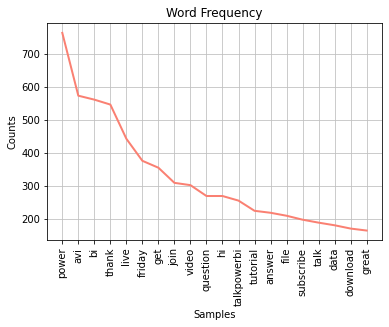

In [11]:
# From lists of comments to a single list containing all words      
all_words=[]        
for i in range(len(comments)):
    all_words = all_words + comments['text'][i]

# Get word frequency        
nlp_words = nltk.FreqDist(all_words)
plot1 = nlp_words.plot(20, color='salmon', title='Word Frequency')

That does not give us much idea about how people feel about the video. Still, here are a few noteworthy mentions:

Let’s look for the most frequent bigrams, which means the most frequent pair of words that are next to each other in a comment.


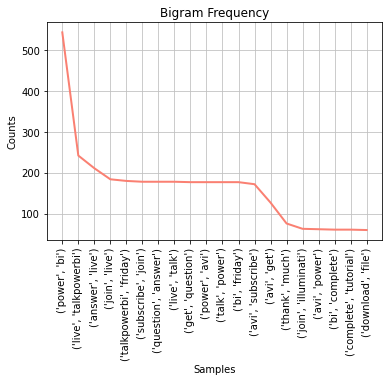

<AxesSubplot:title={'center':'Bigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [12]:
# Bigrams
bigrm = list(nltk.bigrams(all_words))
words_2 = nltk.FreqDist(bigrm)
words_2.plot(20, color='salmon', title='Bigram Frequency')

Now we are starting to see some more interesting stuff. The discussion circulates a lot around the friday live q&a session. 

Here is the plot for the most popular trigrams basically underlining what the bigrams already indicate. 

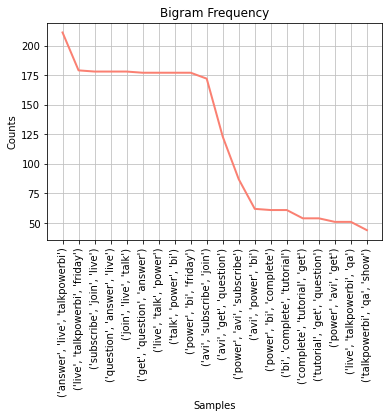

<AxesSubplot:title={'center':'Bigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [13]:
# Let's shift gears to "Trigrams"
trigrm = list(nltk.trigrams(all_words))
words_3 = nltk.FreqDist(trigrm)
words_3.plot(20, color='salmon', title='Bigram Frequency')

Not a lot of new information. 

But can we trust these results? 

#### If we take a closer look at the data it seems the video author is moderating A LOT in the comment section. Therefore, a lot of comments will just express his opinion and the dataset is BIASED ...

#### What if we exclude the author comments? Will this provide another result purely from the user's perspective?

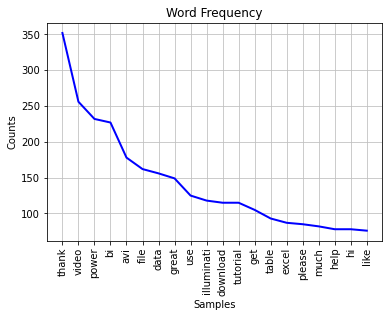

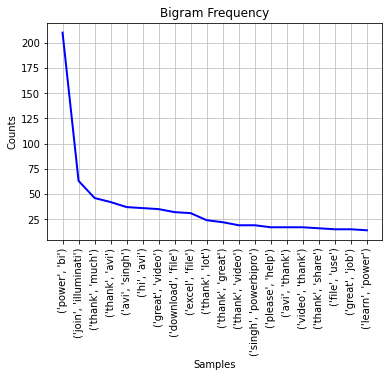

<AxesSubplot:title={'center':'Bigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [14]:
# Get the dataset ready
comments = pd.read_json(r'/Users/fred/OneDrive - Adobe/Data/NLP_sentiment/Youtube_Comments/AGrl-H87pRU_comments.json', lines=True) 
comments = comments[comments.author != "Avi Singh - PowerBIPro"] # Excluding Avi's (the author) comments
comments = comments.reset_index(drop=True)
comments = comments.drop(['cid', 'time', 'author', 'channel', 'votes', 'photo', 'heart'], axis=1)

# Apply the cleaning and lemmatization functions
comments['text'] = comments['text'].apply(lambda x: clean_text(x))
comments['text'] = comments['text'].apply(lambda x: lem(x))

# From lists of comments to a single list containing all words      
all_words=[]        
for i in range(len(comments)):
    all_words = all_words + comments['text'][i]

# Get word frequency        
nlp_words = nltk.FreqDist(all_words)
plot1 = nlp_words.plot(20, color='blue', title='Word Frequency')

# Bigrams
bigrm = list(nltk.bigrams(all_words))
words_2 = nltk.FreqDist(bigrm)
words_2.plot(20, color='blue', title='Bigram Frequency')

Well the discussion did quite shift a lot. 

* No more talking about the PowerBI QA session live event on Friday
* Fun fact. Illuminati are interested in PowerBI, too ;-)

# Sentiment Analysis

### But first. A bit of theory. 

Let's ask wikipedia one last time: 

*Sentiment analysis (also known as opinion mining or emotion AI) refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.*

The sentiment property below returns a named tuple of the form Sentiment(polarity, subjectivity). 

* The polarity score is a float within the range [-1.0=negative to 1.0=positive]
* The subjectivity is a float within the range [0.0 to 1.0] where 0.0 is very objective and 1.0 is very subjective.



In [15]:
# Get sentiment for comment data

comments['text'] = [str(thing) for thing in comments['text']]
sentiment = []
for i in range(len(comments)):
    blob = TextBlob(comments['text'][i])
    for sentence in blob.sentences:
        sentiment.append(sentence.sentiment.polarity)

comments['sentiment'] = sentiment


In [16]:
# Let's take a look at the our dataset with comments.head()

comments.sort_values(by=['sentiment'], ascending=False)


,text,sentiment
478,"['superb', 'thank']",1.000000
791,"['really', 'excellent', 'tutorial', 'thank', 'lot', 'share']",1.000000
436,"['superb', 'piece', 'work', 'avi', 'excellent', 'learn', 'lot', 'powerbi']",1.000000
499,"['awesome', 'introduction']",1.000000
535,"['awesome', 'follow', 'power', 'bi', 'course', 'get', 'understand', 'thing', 'work', 'best', 'course', 'ive', 'come', 'across', 'structure', 'detail', 'like', 'teach', 'style', 'thank', 'lot', 'avi']",1.000000
...,...,...
131,"['unable', 'download', 'data', 'file', 'practice', 'try', 'link', 'give', 'description', 'nothing', 'work']",-0.500000
939,"['unable', 'get', 'file', 'use', 'video']",-0.500000
489,"['pretty', 'pathetic', 'tutorial', 'sign', 'crap', 'get', 'download', 'material', 'make', 'file', 'downloadable', 'link', 'like', 'legitimate', 'people']",-0.516667
79,"['really', 'ugly', 'rhetoric', 'skill', 'bud', 'sad', 'presentation']",-0.600000


Interesting! It seems obvious that the best sentiment comes from comments like "You're awesome man" with a sentiment score of 1.

Well! At the other end with a negative sentiment score it seems someone people did indeed complain. 
E.g. about the PowerBI pricing model. Fortunatelly we don't need to know how expensive PowerBI licenses are ;-) 


<AxesSubplot:title={'center':'Comments Polarity'}, ylabel='Frequency'>

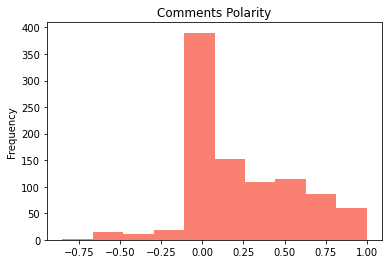

In [17]:

# Let's plot the sentiment as histogram
comments['sentiment'].plot.hist(color='salmon', title='Comments Polarity')

## Now! How could a use case for our team look like.

Let's imagine some user feedback on our reports as below.

In [18]:
### BEFORE YOU CONTINUE READING: 
### QUESTION: What do you think is the sentiment and subjectivity score for the below feedback phrases? ##

PSAI_feedback = pd.DataFrame({'feedback': [
 "PS Analytics & Insights team are the worst",   
 "PS Analytics & Insights team really doesn't perform well these days",   
 "PS Analytics & Insights team",   
 "PS Analytics & Insights team is pretty awesome",   
 "PS Analytics & Insights team is awesome",   
]})







In [19]:
PSAI_feedback['feedback'] = [str(thing) for thing in PSAI_feedback['feedback']] # actually not necessary here.

sentiment = []
subjectivity = []

for i in range(len(PSAI_feedback)):
    blob = TextBlob(PSAI_feedback['feedback'][i])
    for sentence in blob.sentences:
        sentiment.append(round(sentence.sentiment.polarity, 1))
        subjectivity.append(round(sentence.sentiment.subjectivity, 1))

PSAI_feedback["sentiment"] = sentiment
PSAI_feedback["subjectivity"] = subjectivity
PSAI_feedback.head()

,feedback,sentiment,subjectivity
0,PS Analytics & Insights team are the worst,-1.0,1.0
1,PS Analytics & Insights team really doesn't perform well these days,0.2,0.2
2,PS Analytics & Insights team,0.0,0.0
3,PS Analytics & Insights team is pretty awesome,0.6,1.0
4,PS Analytics & Insights team is awesome,1.0,1.0


In [20]:
# Take a closer look at subjectivity. 
# This is an important metric. For example the first sentence appears as very negative feedback. But it is also very subjective, meaning just expressing the opinion of one person and without for detail or prove!! Thus, subjective...


## Let's apply some REAL user feedback from previous survey. 

Below I used some samples from a GU report feedback survey in 2019.

Survey question: What can we do to make your experience better?


In [21]:
survey_feedback = pd.DataFrame({'feedback': [
 "Awesome",   
 "Its just PERFECT",   
 "The ability to sort without looking at Plan, maybe further make it easier by org?", 
 "This session was covering basic which most of the people managed to enable on their own. We would love to have a session to know all extra features and benefits from Power BI report.",   
 "indicate how the performance achieved and confirmation of variable achievement",   
 "Insert the soft booking in the forecast, in order to have a more complete view of the forecast.",   
 "Nothing, thank you for providing an excellent report.",
 "more hands on sessions"
]})

# This time we need to quickly apply our clean function from above since we have long text with punctuation. 
# Otherwise we would get a result for each sentence in 1 feedback, but we want the sentiment for all sentences in 1 feedback)
survey_feedback['feedback'] = survey_feedback['feedback'].apply(lambda x: clean_text(x))
survey_feedback['feedback'] = [str(thing) for thing in survey_feedback['feedback']]



# Let's run a sentiment analysis with default TextBlob
sentiment = []
subjectivity = []

for i in range(len(survey_feedback)):
    blob = TextBlob(survey_feedback['feedback'][i])
    for sentence in blob.sentences:
        sentiment.append(round(sentence.sentiment.polarity, 1))
        subjectivity.append(round(sentence.sentiment.subjectivity, 1))

"""

# Uncomment to leverage NaiveBayes classifier. This could take a while. 
sentiment = []

for i in range(len(survey_feedback)):
    blob = TextBlob(survey_feedback['feedback'][i], analyzer=NaiveBayesAnalyzer())
    for sentence in blob.sentences:
        sentiment.append(sentence.sentiment)
"""

survey_feedback["subjectivity"] = subjectivity
survey_feedback["sentiment"] = sentiment
survey_feedback.head()

,feedback,subjectivity,sentiment
0,['awesome'],1.0,1.0
1,['perfect'],1.0,1.0
2,"['ability', 'sort', 'without', 'looking', 'plan', 'maybe', 'make', 'easier', 'org']",0.0,0.0
3,"['session', 'covering', 'basic', 'people', 'managed', 'enable', 'would', 'love', 'session', 'know', 'extra', 'features', 'benefits', 'power', 'bi', 'report']",0.3,0.2
4,"['indicate', 'performance', 'achieved', 'confirmation', 'variable', 'achievement']",0.0,0.0


##### Again the results are interesting. 

* While the first two comments are "nice to have" they are super subjective and therefore do not deliver a tangible result to derive actions from (except to be happy maybe... ;-) )
* The 3rd sentence actually was a question -> so neither positive/negative nor subjective/objective
* Finally, the 4th sentence implies that the training session was just providing basic content that the users already knew.
* Thus, our classifier corretly tells us: This seems to be valid feedback ("pretty objective") and the user wasn't very happy (sentiment score 0.2)

# Whats'next? 

* If you made it all through the notebook until this point, why don't you let me know what you think of this approach. Just reach out!!!! 

Fred ;-)
